![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# XAI in deep learning-based image analysis: Explain CNNs

---

In this third tutorial, we are going to compare different explainability methods for image classification performed with CNNs. We will:
- Apply Grad-CAM on a new image
- Use the SHAP library to get the SHAP values on the same image
- Compare the two methods
- Discuss the limitation of XAI for CNNs

## Setup Colab environment

If you installed the packages and requirements on your own machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button. This will open this page in the Colab environment and you will be able to execute the code on your own.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/xai-model-specific/Tutorial_XAI_for_ImageAnalysis.ipynb)

In [ ]:
#@markdown Now that you are visualizing the notebook in Colab:

#@markdown * Run this cell to connect your Google Drive to Colab and install packages
#@markdown * Permit this notebook to access your Google Drive files. Click on 'Yes', and select your account.
#@markdown * Google Drive for desktop wants to access your Google Account. Click on 'Allow'.
#@markdown At this point, a folder has been created in your Drive and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive.

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
!git clone https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
%cd XAI-Tutorials

In [1]:
# Installing the necessary packages

import numpy as np
import cv2 as cv
import shap
import json
import matplotlib.pyplot as plt
%matplotlib inline 
import torch, torchvision
from torch import nn
from torchvision import transforms, models, datasets
from torchvision.models import resnet50,ResNet50_Weights
import sys  
sys.path.append('../data_and_models/')
from model_gradcam import GradCamModel

## Image explanation

As mentioned in the introduction, there are two main kinds of explainability methods for images:

- occlusion- or perturbation-based methods
- gradient-based methods

The first ones consist of manipulating/masking parts of the image to generate explanations. Some examples of these are LIME and SHAP.
The second one consists of leveraging the gradient of the function so that a mapping of the function value onto multiple input dimensions is readily obtained. There are many gradient-based methods (e.g. Grad-CAM, Integrated Gradients, SmoothGradthat differ in how these gradients are computed.

In this tutorial, we will compare the results from Grad-CAM with the SHAP library that we already used in the first part of the course.
In particular, this library combines together occlusion- and gradient-based methods, providing a visual explanation that is very similar to the SHAP values you are already familiar with.

### GradCAM results

Let's start opening the results of the Grad-CAM implementation on our iguana image.

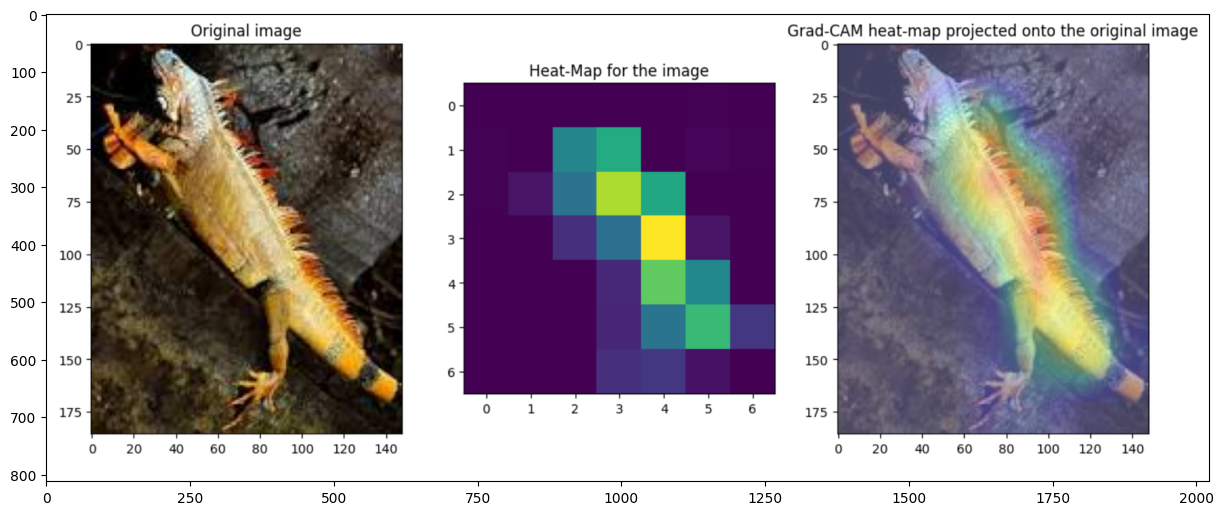

In [2]:
# read and visualize the image

def read_img(path_to_img):
    img = cv.imread(path_to_img) # Insert the path to image.
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img
    
path_to_img = '../docs/source/_figures/iguana_GradCAM.png'
img = read_img(path_to_img)
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.show()

## SHAP for image classification

### How does SHAP work?
To summarize what we learnt in the first part of the course:

* SHAP is based on the computation of the **Shapley values**, a method to calculate the contributions of each player to the outcome of a game.
* The Shapley values are calculated with all possible combinations of players. Given N players, it has to calculate outcomes for 2^N combinations of players. In the case of machine learning, the “players” are the features (e.g. pixels in an image), and the “outcome of a game” is the model’s prediction. Calculating the contribution of each feature is not feasible for large numbers of N. For example, for images, N is the number of pixels.
* Therefore, SHAP does not attempt to calculate the actual Shapley value. Instead, it uses sampling and approximations to calculate the SHAP value.
  
In the SHAP library, there are multiple explainers that can be used to explain which features are important in an image for classification. Some of them are:
* [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html)
* [PartitionExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.PartitionExplainer.html)
* [GradientExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.GradientExplainer.html#shap.GradientExplainer)

All of the above uses specific methods to approximate SHAP values for deep learning models.
In this course, we will focus on the implementation of GradientExplainer, but you can read more about each explainer in the [SHAP documentation](https://shap-lrjball.readthedocs.io/en/latest/api.html#core-explainers).

**GradientExplainer**

We won't go into the details here but we will rather focus on the interpretation of the results. As a reference, we summarize the main concepts and we recommend reading the SHAP documentation and the book [Interpreting Machine Learning Models With SHAP](https://leanpub.com/shap) (Molnar 2022). 
Many models, including several neural networks, are gradient-based. This means that we can compute the gradient of the loss function with respect to the model input. When we can compute the gradient with respect to the input, we can use this information to calculate SHAP values more efficiently. There’s a connection between the Gradient Estimator and a method called Integrated Gradients (Sundararajan et al. 2017). Integrated Gra- dients is a feature attribution method also based on gradients that outputs the integrated path of the gradient with respect to a reference point as an explanation. The difference between Integrated Gradients and SHAP values is that Integrated Gradients use a single reference point, while Shapley values utilize a background data set.

### How to visualize SHAP attributions?
SHAP uses colors to explain attribution:
- Red pixels increase the probability of a class being predicted
- Blue pixels decrease the probability of a class being predicted

The image below (credit: [SHAP documentation](https://github.com/shap/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models)), is the output of the DeepExplainer for four digits on the MNIST dataset. The input images are shown on the left column and the other columns show the SHAP value for the classes from 1 to 9, with the original image nearly transparent grayscale backings behind each of the explanations. The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset) and the current model output. Note that for the 'zero' image the blank middle is important, while for the 'four' image the lack of a connection on top makes it a four instead of a nine.

![](https://raw.githubusercontent.com/shap/shap/master/docs/artwork/mnist_image_plot.png)

### SHAP on a custom image

Let's start loading the iguana image and the ImageNet classes.

In [3]:
# read and visualize the image
path_to_img = '../data_and_models/images/Iguana.jpeg'
img = read_img(path_to_img)


# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

Before passing the image to SHAP, we need to transfomr it using the ImageNet transformation (transform to tensor, resize, normalize). In the next cell we define the functions necessary for the image transformations.

In [4]:
# define the transformations (here we are using the ImageNet transformations)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def transform_img(img, tensor_flag=True ):
    transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
    arr_img = np.array(img)
    # apply the transforms
    trans_img = transform(arr_img)
    # unsqueeze to add a batch dimension
    trans_img = trans_img.unsqueeze(0)
    if tensor_flag is False:
        # returns np.array with original axes
        trans_img = np.array(trans_img)
        trans_img = trans_img.swapaxes(-1,1).swapaxes(1, 2)

    return trans_img

def normalize_and_adjust_axes(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axes so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

We define the CNNs model that we will use for the classifcation with the same ResNet50 architecture we already used in the previous tutorials.

In [5]:
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).eval()

We can now focus on SHAP implementation.
#### Step 1 - Create a baseline
We select part of the ImageNet data set to create a baseline, i.e. the background dataset to use for integrating our features.

In [6]:
X, y = shap.datasets.imagenet50()

#### Step 2 - Instantiate the class
We decided to focus on GradientExplainer which ...
The first argument is tuple containing the model and the layer (if the input is a tuple, the returned shap values will be for the input of the layer argument). The second argument is the background dataset.

In [7]:
e = shap.GradientExplainer((model, model.layer4), normalize_and_adjust_axes(X))

#### Step 3 - Compute SHAP values on the custom image
In the shap_value method we pass the image we want to explain as a tensor, and setting ranked_outputs=2 we only explain the top 2 model outputs.

*Please note that it could take some time to compute the SHAP values.*

In [8]:
img_to_explain = transform_img(img)
shap_values, indexes = e.shap_values(img_to_explain, ranked_outputs=4)

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


#### Step 4 - Plot results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


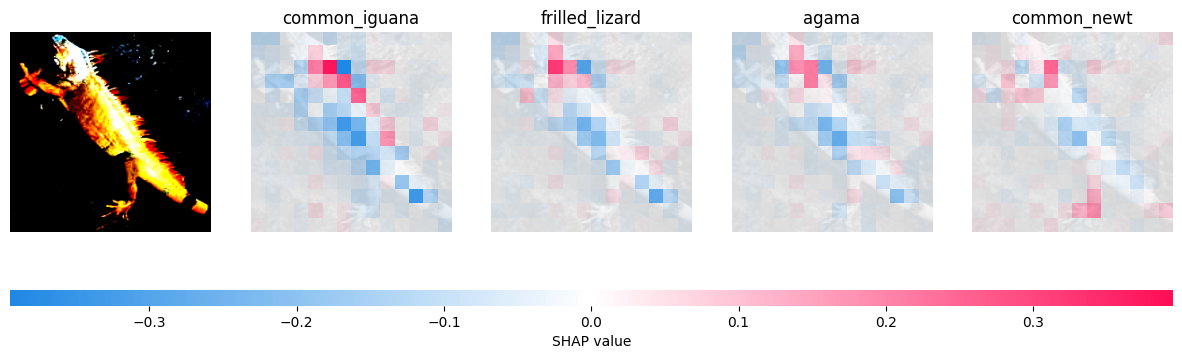

In [9]:
# Get classes names
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# Transform image for plotting
img_explained_to_plot = transform_img(img, False)

# Plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values] # unroll the axes
shap.image_plot(shap_values, img_explained_to_plot, index_names)

<font color='green'>

#### Question 1: Does the explanation make sense to you? What do you observe? If you don't know these species, check out on the web the images for the different classes

<font color='grey'>

#### Your Answer: 

As mentioned before, the red pixels contribute positively to the respective class, while the blue pixels contribute negatively. Grey pixels have a near-zero SHAP value. We can see that the rows of spines running down the back are contributing to the prediction of the iguana class, and not to the frilled lizard one. For the last two displayed classes the area of the paws is the one that is contributing more toward the prediction.

<font color='green'>

#### Question 2: Why SHAP is also considered a contrastive method?

#### Help: think about the role of the baseline, can you think about other ways to create a baseline for images (image with no features)?

<font color='grey'>

#### Your Answer:

Selecting a baseline or reference dataset in explainability methods like SHAP can be considered a contrastive method. It contrasts the features of the input data (e.g., an image with a specific feature) with those of a reference or baseline dataset (e.g., an image without that feature). This contrastive approach helps in quantifying how much each feature contributes to the model's prediction relative to the baseline, aiding in the interpretation of the model's behavior. Another conceptual limitation is the choice of a baseline. The attributions are not absolute values. They are the contributions compared to a baseline. (https://distill.pub/2020/attribution-baselines/)

<font color='green'>

#### Question 3: What do you think are the strengths and weaknesses of SHAP on image classification?

<font color='grey'>

#### Your Answer: 
Pros:
- Model-agnostic: SHAP can be applied to any machine learning model, not limited to CNNs, making it versatile for different architectures.
- Global and local interpretability: SHAP provides both global and local interpretability, allowing you to understand feature importance for individual predictions and the model's overall behavior.
- Quantitative explanations: It assigns attribution values to each feature (e.g., pixels in an image), providing a quantitative measure of their impact on the model's decision.
- Consistency: SHAP values adhere to Shapley values, which have a solid theoretical foundation in cooperative game theory.

Cons:
- Computationally intensive: Computing SHAP values can be resource-intensive, especially for complex models and large datasets.
- Complexity: Understanding and implementing SHAP values may require a deeper understanding of the SHAP framework and concepts like cooperative game theory.
- Some approximation is required: For deep learning models, exact SHAP values are often infeasible to compute, so approximations are used, potentially leading to less precise explanations.
- The choice of baseline images can significantly affect SHAP results (or any method that relies on baselines) - https://distill.pub/2020/attribution-baselines/



## Comparing Grad-CAM and SHAP

<font color='green'>

#### Exercise: Think about the difference between the two explainability methods for images that we introduced. Discuss and complete the table together with your team


| **Aspect**                | **Grad-CAM**                             | **SHAP (SHapley Additive exPlanations)**    |
|---------------------------|-----------------------------------------|--------------------------------------------|
| **Explanation Type**      |  |  |
| **Interpretability**      |  |  |
| **Model Compatibility**   |  |  |
| **Baseline Choice**       |  |  |
| **Quantitative Measure**  |  |  |
| **Complexity**            |  |  |
| **Theoretical Basis**     |  |  |
| **Implementation**        |  |  |
| **Output**                |  |  |


<font color='grey'>

#### Your Answer: 

<img src="../../docs/source/_figures/comparison_GradCAM_SHAP.png" alt="Image Title" width="700" height="700">


## Limitations of XAI for images

In this section, we want to collect some examples of the limitations of methods, to underline that it's important to use XAI methods, but we cannot trust them blindly. Among several works, we selected three paper that we advise you to read.

- **Relevance and resistance of saliency maps**: According to the paper ["Overlooked Trustworthiness of Saliency Maps
"](https://link.springer.com/chapter/10.1007/978-3-031-16437-8_43) from Zhang et al., 2022, these two parameters of saliency maps should be taken into consideration in future works to validate the trustworthiness of medical AI explainability. Indeed, as shown in the picture below,it might happen that different predictions might have similar or same saliency map (lack of relevance) or that same predictions might have different saliency maps (lack of resistance).

![Title](../../docs/source/_figures/relevance_resistance.png)

- **Saliency Map can be misleading**: In the paper ["Stop Explaining Black Box Models for High Stakes Decisions and Use Interpretable Models Instead](https://arxiv.org/abs/1811.10154)" (Rudin, 2018) the author underlines how saliency maps are often considered to be explanatory. Saliency maps can be useful to determine what part of the image is being omitted by the classifier, but this leaves out all information about how relevant information is being used. Knowing where the network is looking within the image does not tell the user what it is doing with that part of the image, as illustrated in the figure below. In fact, the saliency maps for multiple classes could be essentially the same; in that case, the explanation for why the image might contain a Siberian husky would be the same as the explanation for why the image might contain a transverse flute.
  
![Title](../../docs/source/_figures/Husky.png)

- **Disagreement Problem**: As shown in the paper ["The Disagreement Problem in Explainable Machine Learning: A Practitioner’s Perspective"](https://arxiv.org/abs/2202.01602)  (Krishna et al., 2022) different models could bring to a different explanation, and it's important to question which one we should consider more reliable for our task at hand.
![Title](../../docs/source/_figures/comparison.png)

## Extra Material: Adversarial attacks & Explainability Methods

### Adversarial Attacks

An **adversarial attack** ([Goodfellow et al., 2014](https://arxiv.org/abs/1406.2661)) consists of subtly modifying an original image in such a way that the changes are almost undetectable to the human eye. The modified image is called an adversarial image, and when submitted to a classifier is misclassified, while the original one is correctly classified.

![Title](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*PmCgcjO3sr3CPPaCpy5Fgw.png)
[Image credit](https://arxiv.org/abs/1412.6572)

<font color='green'>

#### Question 4: Can you think about some situation where these adversarial attack could be very dangerous?

<font color='grey'>

#### Your Answer: 
For example:
- Autonomous driving vehicles: Traffic signs could be modified and cause an accident
- Inappropriate content: Illegal content could be modified so that it's undetectable by content moderation algorithms and used in popular websites or by police web crawlers (search engine bots download and indexes content from all over the Internet)
- Medical Diagnosis: Attackers could craft subtle perturbations in medical images that cause the classifier to misdiagnose diseases. For example, a benign lesion might be classified as malignant.
- Facial Recognition: Adversarial attacks on facial recognition systems deployed for surveillance or access control, like masking or altering faces might make people unrecognizable to facial recognition systems while appearing unchanged to human observers. Consequence: Privacy violations, unauthorized access, and identity theft could occur. Security measures relying on facial recognition may become unreliable.


Deep Neural Networks (DNNs) and Convolutional Neural Networks (CNNs), while being the cutting-edge algorithms for numerous imaging tasks, pose a challenge. These black-box models, despite their remarkable accomplishments, are not suitable for handling sensitive and critical tasks discussed earlier. To effectively implement them in these domains, addressing the fragility of these black-box models against adversarial attacks is imperative.

### XAI as a defense strategy

As shown in the figure below [Klawikowska et al., 2020](https://link.springer.com/chapter/10.1007/978-3-030-61401-0_14) the predicted class can change after an adversarial attack, but using explainability heatmaps can help to detect the reason for the misclassification. The upper row contains the input images that are given to the input of the neural network, while the lower row depicts the corresponding heatmaps
In panel a), we observe the original image where a Deep Neural Network (DNN) correctly classifies it as a cat with high accuracy. In columns b) and d), we notice the differences in the maps after adversarial attacks (Fast Gradient Sign Method (FGSM) and pixel-level attacks), leading to incorrect predictions. In the first case, the colors of the maps are flipped (and thus the pixel significance), and in the second case, it is clearly visible that the network is focusing its attention on this single, adverse pixel.

The paper introduces an adversarial retraining strategy (results are shown in columns c) and e)) that significantly improves results by enabling the correct classification despite the adversarial attacks


![](../../docs/source/_figures/adversarial_attacks_and_xai.png)

### Adversarial attacks for XAI methods robustness

While our focus has been on the application of XAI methods for detecting adversarial attacks, an emerging and promising research area takes a different perspective: investigating the use of adversarial attacks as a means to evaluate the robustness of XAI methods.

We cannot go into the details, but if you're curious, we suggest beginning your exploration with this survey [Banieckil et al., 2022](https://arxiv.org/pdf/2306.06123.pdf).

---
Congratulations! You completed this tutorial.